In [1]:
### Global 
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from chainconsumer import ChainConsumer

### Local 
import utilities_simple_mauro as utilities

import importlib as imp
imp.reload(utilities);

In [2]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = { 'OmegaM' : 0.2999,
                 'OmegaDE': 0.7,
                 'OmegaR' : 1.e-4,
                 'h'      : 0.7 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

# Set parameters for step
fstar = 0.8
c0    = 0.9
w1    = 0.5

# Points in frequency 
f_points = 300

In [3]:
# Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0], ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [4]:
# Get mass quantities
m_eff  = m1*m2/(m1+m2)
Ms     = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta    = ((m1+m2)/Ms)**(-5./3)

Dl_s   = Dl*Mpc/c        # Dl in sec

Ms_s   = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut   = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc      = utilities.inspiral_fc(Mtot_s)
farr    = np.logspace(np.log10(f_start), np.log10(fc), num=f_points)  #inspiral range only
f_plot  = np.logspace(np.log10(f_start), np.log10(f_cut), num=f_points)     # full IMR waveform

Dl_arr  = np.array([Dl_s]*len(farr))

In [5]:
# Waveforms for inspiral and IMR, in GR
pars_labels = [r'$\log(Mc)$', r'$\log(\eta)$', r'$\log(z)$', r'$t_c$', r'$\psi_c$', r'$c$']
pars_GR     = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR        = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot      = utilities.waveform(f_plot, pars_GR, cosmo_params)

print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [6]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=f_points)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=f_points)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


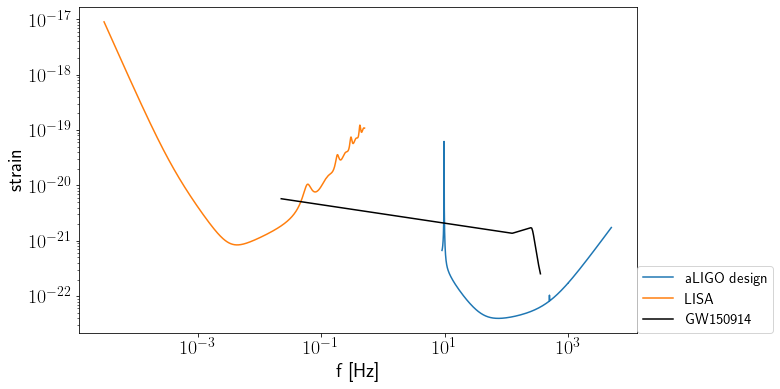

In [7]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0));

In [8]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR =', SNR_ligo)
print('LISA SNR =', SNR_lisa)

design LIGO SNR = 65.53226762131281
LISA SNR = 3.4325136604113045


# Start defining all the things for the derivatives

In [9]:
def numerical_derivative(func, par, dx, conv=5e-2, factor=.5, order=5, verbose=False):
    factor  = factor if factor < 1 else .5
    ratio   = 1e8
    r_best  = 1e8
    dx_best = 0.
    
    while ratio > conv:
        d1    = derivative(func, par, dx=dx/2, order=int(order))
        d2    = derivative(func, par, dx=dx *2, order=int(order))
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e6
        else:
            ratio = np.mean(r_vec)
        
        if ratio < r_best:
            dx_best = dx
            r_best  = ratio
        
        dx *= factor  
        
        if dx < 1e-15:
            #print(par, dx)
            #raise ValueError('No convergence')
            ratio = 1e-1 *conv
    
    print('Ratio best = %.2e for dx = %.2e' % (r_best, dx_best))
    return derivative(func, par, dx=dx_best, order=int(order))

Ratio best = 4.09e-02 for dx = 1.95e-03
(array([], dtype=int64),)


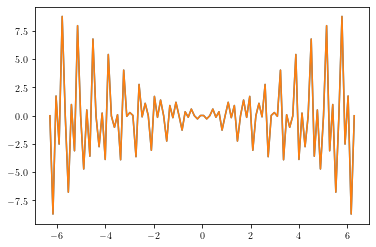

In [10]:
# Just a test of my function to compute derivatives
der_ord  = 5
a_val    = 10
b_val    = 6
x        = np.linspace(-2 *np.pi, 2 * np.pi, 100)
my_func  = lambda a : np.sin(a * x)**b_val

analytic = b_val *x *np.cos(a_val *x) *np.sin(a_val * x)**(b_val -1)
dsin     = numerical_derivative(my_func, a_val, 1, order=int(der_ord))

plt.plot(x, dsin)
plt.plot(x, analytic)

test     = (dsin -analytic ) / dsin
print( np.where(test[1:-1] > 5e-2 ) )

In [11]:
def my_wf(farr, pars, psd, cosmo_params, which_wf='GR', width=0, dist_corr=True):
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cT_type='step', width=width).h_Delta_exact
    
    if dist_corr==False:
        hf = waveform(farr, pars, cosmo_params, dist_corr=False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    return waveform, hf

In [12]:
def f_to_der(index, val, function, *args, **kwargs):
    pars        = np.array(args[1])
    pars[index] = val
    return function(args[0], pars, *args[2:], **kwargs)

def get_one_derivative(ind, farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, 
        dist_corr=True, order=3, factor=.5, verbose=False):
    t0 = tm.perf_counter()
    print('- Working on index', ind)
    
    waveform, hf = my_wf(farr, pars, psd, cosmo_params, which_wf=which_wf, width=width, dist_corr=dist_corr)
    to_der       = lambda par_val : f_to_der(ind, par_val, waveform, farr, pars, cosmo_params) / hf 
    dx           = np.abs(.1 *pars[ind]) if pars[ind] != 0 else 1e-1
        
    if ind == 3:
        # Analytical derivetives w.r.t. tc
        my_der   = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
        
    elif ind == 4:
        # Analytical derivetives w.r.t. psic
        my_der   = -1.j*waveform(farr, pars, cosmo_params)
        
    elif ind == 5:
        if MG_flag:
            my_der = numerical_derivative(to_der, pars[ind], dx=dx, order=order, 
                        factor=factor, verbose=verbose) * hf
        else:
            my_der = []
        
    else:
        if ind == 0:
            dx     = 1e-2
        my_der     = numerical_derivative(to_der, pars[ind], dx=dx, order=order, 
                        factor=factor, verbose=verbose) *hf
    
    print('Derivative computed in %.2f seconds \n' % (tm.perf_counter() -t0))
    return np.array(my_der)

In [13]:
def get_derivatives(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, dist_corr=True, 
        order=3, factor=.5, verbose=False):
    
    t0 = tm.perf_counter()
    print('--- Here I start computing all the derivatives \n')
    derivatives = []
    
    for ind in range(0, len(pars) -1):
        if ind < 5:
            derivatives.append( get_one_derivative(ind, farr, pars, psd, cosmo_params, which_wf=which_wf, 
                    MG_flag=MG_flag, width=width, dist_corr=dist_corr, order=order, 
                    factor=factor, verbose=verbose) ) 
        elif MG_flag:
            derivatives.append( get_one_derivative(ind, farr, pars, psd, cosmo_params, which_wf=which_wf, 
                    MG_flag=MG_flag, width=width, dist_corr=dist_corr, order=order, 
                    factor=factor, verbose=verbose) ) 

    print('All derivatives in %.2f seconds' % (tm.perf_counter() -t0))
    return np.array(derivatives)

In [14]:
ders = get_derivatives(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR', dist_corr=True, 
        order=5, factor=.5, verbose=False)

--- Here I start computing all the derivatives 

- Working on index 0
Ratio best = 4.55e-03 for dx = 7.63e-08
Derivative computed in 4.10 seconds 

- Working on index 1
Ratio best = 8.59e-03 for dx = 5.46e-04
Derivative computed in 2.27 seconds 

- Working on index 2
Ratio best = 1.86e-03 for dx = 2.41e-01
Derivative computed in 0.40 seconds 

- Working on index 3
Derivative computed in 0.05 seconds 

- Working on index 4
Derivative computed in 0.05 seconds 

All derivatives in 6.87 seconds


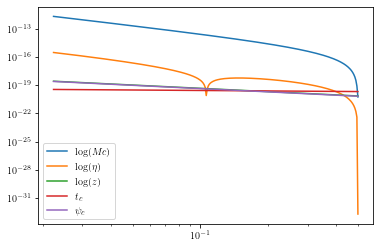

In [15]:
for i in range(0, len(ders)):
    plt.loglog(farr_lisa, np.abs(ders[i]), label=pars_labels[i]);
plt.legend(loc=3);

In [16]:
c0        = .99
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]

In [17]:
dders = get_one_derivative(1, farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', 
            MG_flag=True, width=.01, dist_corr=False, order=5, factor=.3)

- Working on index 1
Ratio best = 4.72e-03 for dx = 3.40e-04
Derivative computed in 1.67 seconds 



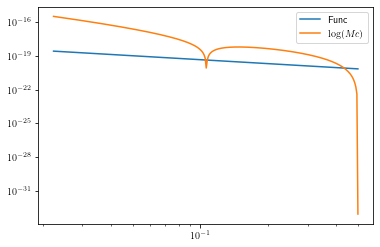

In [18]:
mwf, my_hf = my_wf(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', width=.9, dist_corr=True)

plt.loglog(farr_lisa, np.abs(my_hf), label='Func')
plt.loglog(farr_lisa, np.abs(dders), label=pars_labels[0])
#plt.ylim(1e-21, 1e-17)
plt.legend(loc=1);

In [19]:
dders = get_derivatives(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', 
            MG_flag=True, width=w1, dist_corr=False, order=5, factor=.1)

--- Here I start computing all the derivatives 

- Working on index 0
Ratio best = 1.26e-02 for dx = 1.00e-07
Derivative computed in 1.77 seconds 

- Working on index 1
Ratio best = 4.02e-03 for dx = 1.40e-04
Derivative computed in 1.12 seconds 

- Working on index 2
Ratio best = 1.86e-03 for dx = 2.41e-01
Derivative computed in 0.40 seconds 

- Working on index 3
Derivative computed in 0.05 seconds 

- Working on index 4
Derivative computed in 0.05 seconds 

- Working on index 5
Ratio best = 7.75e-03 for dx = 9.90e-02
Derivative computed in 0.39 seconds 

All derivatives in 3.78 seconds


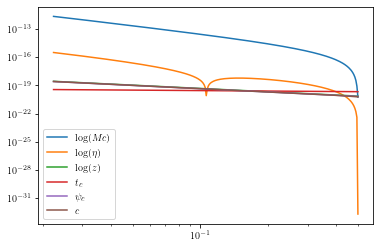

In [20]:
for i in range(0, len(dders)):
    plt.loglog(farr_lisa, np.abs(dders[i]), label=pars_labels[i]);
#plt.ylim(1e-22, 1e-15)
plt.legend(loc=3);

In [21]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_matrix(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, dist_corr=True, 
        order=3, factor=.5, verbose=False, derivatives=None):
    
    t0 = tm.perf_counter()
    print('--- Here I start computing fishers \n')
    
    if derivatives is None:
        print('Will recompute derivatives')
        derivatives = get_derivatives(farr, pars, psd, cosmo_params, which_wf=which_wf, 
                        MG_flag=MG_flag, width=width, dist_corr=dist_corr, order=order, 
                        factor=factor, verbose=verbose)
    
    else:
        print('Will use derivatives as passed to this function')
        
    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]
    
    connum = np.linalg.cond(Fisher_matrix)
    print('Condition number (div by 1e15)',connum/1.e15)
    print('This took %.2f seconds \n' % (tm.perf_counter() -t0) )
    
    return Fisher_matrix

In [22]:
Fisher = Fisher_matrix(farr_lisa, pars_step, lisa_psd, cosmo_params, derivatives=dders)

--- Here I start computing fishers 

Will use derivatives as passed to this function
Condition number (div by 1e15) 145617.85790433304
This took 0.00 seconds 



# GR Constraints

In [ ]:
ders_ligo, fisher_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
cov_matrix_ligo = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

In [ ]:
fisher_ligo

In [ ]:
ders_lisa, fisher_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR') 
cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

In [ ]:
fisher_lisa

In [ ]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)

In [ ]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa');
cc.plotter.plot();

# Step function constraints

In [ ]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.5

In [ ]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

In [ ]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [ ]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

h_Delta_step_w1_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step, cosmo_params)
h_Delta_step_w1_fid_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step_fid, cosmo_params)

h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params,dist_corr=False)

# For plotting only
h_Delta_step_w1_plot = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)

In [ ]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1_plot), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15);
# plt.savefig('../plots/amp_psd_step.pdf')

In [ ]:
#mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
#mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

#ligo_psd = ligo_interp(farr[mask_ligo])**2
#lisa_psd = lisa_interp(farr[mask_lisa])

In [ ]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1_ligo, h_Delta_step_w1_ligo, ligo_psd, farr_ligo)
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid_ligo, h_Delta_step_w1_fid_ligo, ligo_psd, farr_ligo)
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1, h_Delta_step_w1, lisa_psd, farr_lisa)
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid, h_Delta_step_w1_fid, lisa_psd, farr_lisa)
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

In [ ]:
# Constraints for fiducial and non-fiducial models
ders_lisa_step, fisher_lisa_step = Fisher_det(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

ders_lisa_step_distcorr, fisher_lisa_step_distcorr = Fisher_det(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
cov_matrix_lisa_step_distcorr = np.linalg.inv(fisher_lisa_step_distcorr)

ders_lisa_step_fid, fisher_lisa_step_fid = Fisher_det(farr_lisa, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
cov_matrix_lisa_step_fid = np.linalg.inv(fisher_lisa_step_fid)

ders_lisa_step_fid_distcorr, fisher_lisa_step_fid_distcorr = Fisher_det(farr_lisa, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
cov_matrix_lisa_step_fid_distcorr = np.linalg.inv(fisher_lisa_step_fid_distcorr)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))
pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))
pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))
pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)
print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)
print('fiducial')
print(pconstraints_lisa_step_fid)
print('fiducial with dist corr')
print(pconstraints_lisa_step_fid_distcorr)


In [ ]:
# plot derivatives
plt.figure()
plt.title('LISA without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()


In [ ]:
# plot derivatives
plt.figure()
plt.title('LISA with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [ ]:
# plot derivatives
plt.figure()
plt.title('LISA with fiducial values without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [ ]:
# plot derivatives
plt.figure()
plt.title('LISA with fiducial values with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [ ]:
wf = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact

def to_der(par):
    ppars = np.array(pars_step)
    ppars[0] = par
    return wf(farr_lisa, ppars, cosmo_params, dist_corr=True)

dM = numerical_derivative(to_der, pars_step[0], 1e-1)

In [ ]:
dM

In [ ]:
np.array(ders_lisa_step_distcorr)[0]

In [ ]:
( dM -np.array(ders_lisa_step_distcorr)[0] ) / dM

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = np.array(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = np.array(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [ ]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = np.array(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

In [ ]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


In [ ]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();


In [ ]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();

In [ ]:
cc = ChainConsumer()

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r');
cc.plotter.plot();

In [ ]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

In [ ]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [ ]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')